In [1]:
%matplotlib inline
from sklearn import manifold, datasets
from scipy.spatial import distance

import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
class TSNE(object):
    
    def __init__(self, n_components=2, perplexity=30, lr=1, eps=1e-9, n_iter=2000, device='cpu'):
        self.perplexity = perplexity
        self.lr = lr
        self.eps = eps
        self.n_iter = n_iter
        self.device = device
        self.n_components = n_components
    
    def t_distribution(self, y):
        n = y.shape[0]
        dist = torch.sum((y.reshape(n, 1, -1) - y.reshape(1, n, -1)) ** 2, -1)
        affinity = 1 / (1 + dist)
        affinity *= (1 - torch.eye(n, device=self.device))  # set diag to zero
        q = affinity / affinity.sum() + self.eps
        return q
    
    def fit_transform(self, x):
        dist2 = distance.squareform(distance.pdist(digits.data, metric='sqeuclidean'))
        p = distance.squareform(manifold.t_sne._joint_probabilities(dist2, self.perplexity, False)) + self.eps

        p = torch.tensor(p, device=self.device, dtype=torch.float32).reshape(-1)
        log_p = torch.log(p)

        y = torch.randn([dist2.shape[0], self.n_components], device=self.device, requires_grad=True)
        optimizer = optim.Adam([y], lr=self.lr)
        criterion = torch.nn.KLDivLoss()

        t = time.time()
        for i_iter in range(self.n_iter):
            q = self.t_distribution(y).reshape(-1)
            loss =  (p * (log_p - torch.log(q))).sum()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        return y.detach().cpu().numpy()

# 运行效果

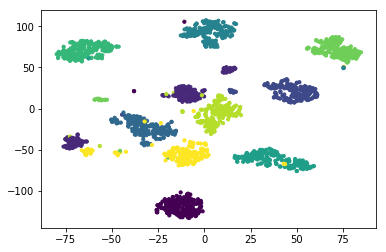

In [3]:
digits = datasets.load_digits(n_class=10)
embed = TSNE(n_components=2, perplexity=30, lr=1, eps=1e-9, n_iter=2000, device='cuda').fit_transform(digits.data)
plt.scatter(embed[:, 0], embed[:, 1], c=digits.target, s=10)
plt.show()

# 运行时间比较

In [4]:
sklearn_tsne = manifold.TSNE(n_components=2, perplexity=30.0, n_iter=2000)
my_tsne = TSNE(n_components=2, perplexity=30, lr=1, eps=1e-9, n_iter=2000, device='cuda')

n_samples = []
ts_sklearn, ts_ours = [], []
for n_class in range(2, 11):
    digits = datasets.load_digits(n_class=n_class)
    n_samples.append(digits.data.shape[0])
    
    tic = time.time()
    embed = sklearn_tsne.fit_transform(digits.data)
    ts_sklearn.append(time.time() - tic)
    print("sklearn_tsne", n_class, digits.data.shape, time.time() - tic)

    tic = time.time()
    embed = my_tsne.fit_transform(digits.data)
    ts_ours.append(time.time() - tic)
    print("ts_ours", n_class, digits.data.shape, time.time() - tic)

sklearn_tsne 2 (360, 64) 3.137336492538452
ts_ours 2 (360, 64) 3.2907328605651855
sklearn_tsne 3 (537, 64) 5.085336208343506
ts_ours 3 (537, 64) 4.221619606018066
sklearn_tsne 4 (720, 64) 6.512163162231445
ts_ours 4 (720, 64) 5.1295740604400635
sklearn_tsne 5 (901, 64) 8.282955408096313
ts_ours 5 (901, 64) 6.28378438949585
sklearn_tsne 6 (1083, 64) 10.13916540145874
ts_ours 6 (1083, 64) 7.920135021209717
sklearn_tsne 7 (1264, 64) 12.400562524795532
ts_ours 7 (1264, 64) 9.991300582885742
sklearn_tsne 8 (1443, 64) 14.367775201797485
ts_ours 8 (1443, 64) 12.398640155792236
sklearn_tsne 9 (1617, 64) 16.46432590484619
ts_ours 9 (1617, 64) 15.230045795440674
sklearn_tsne 10 (1797, 64) 19.22202181816101
ts_ours 10 (1797, 64) 18.682767868041992


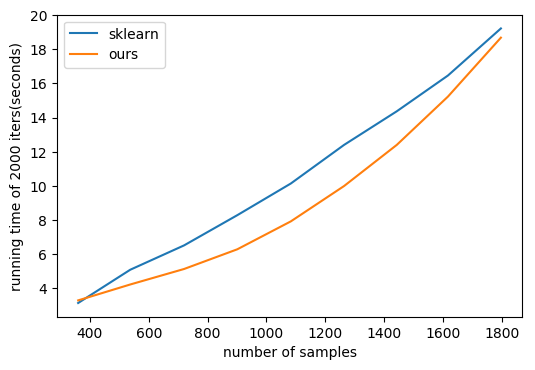

In [5]:
plt.figure(dpi=100)
plt.plot(n_samples, ts_sklearn, label='sklearn')
plt.plot(n_samples, ts_ours, label='ours')
plt.xlabel('number of samples')
plt.ylabel('running time of 2000 iters(seconds)')
plt.legend()
plt.savefig('runtime.pdf')